# <font size="6">Libraries</font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import os, sys
from tqdm import tqdm

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

print('torch version:', torch.__version__)

import ptls
from ptls.data_load import IterableChain
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.data_load.iterable_processing.to_torch_tensor import ToTorch
from ptls.data_load.iterable_processing_dataset import IterableProcessingDataset
from ptls.data_load.datasets.parquet_dataset import ParquetDataset, ParquetFiles

import pytorch_lightning as pl

from glob import glob

import sklearn
from sklearn.model_selection import train_test_split

import os, sys

from src import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

log = utils.get_logger(__name__)

%load_ext autoreload
%autoreload 2

#!pip install python-Levenshtein
#from Levenshtein import distance as lev

torch version: 1.12.1+cu102
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train model

# <font size="5">data conf</font>

In [3]:
dataset_conf = {
    # 'min_seq_len': min(dataset['trx_count'].unique()),
    'min_seq_len': 1,
    'event_col': 'amnt_mcc_bins',
    # 'amount_log': 'amnt',
    'event_cnt_col': 'trx_count',
    'time_col': 'time',
    'id_col': 'app_id'
}

# <font size="5">dataloaders</font>

In [4]:
train_data = glob('data/train.parquet')
valid_data = glob('data/valid.parquet')

class TimeProc(IterableProcessingDataset):
    
    def __init__(self, time_col, tmin, tmax):
        super().__init__()
        self._time_col = time_col
        self.tmin, self.tmax = tmin, tmax
        
    def __iter__(self):
        for rec in self._src:
            features = rec[0] if type(rec) is tuple else rec
            rec[self._time_col] = np.array((features[self._time_col] - self.tmin) / (self.tmax-self.tmin))
            yield rec
            

def pp_collate_fn(time_col, event_col, event_cnt_col, id_col):

    def fn(batch):
        es, ts, ls, ids = [], [], [], []
        
            
        for rec in batch:
            ts.append(rec[time_col])
            es.append(rec[event_col])
            ls.append(rec[event_cnt_col] - 1)
            ids.append(rec[id_col])
            
        ret = [torch.nn.utils.rnn.pad_sequence(ts, batch_first=True), 
               torch.nn.utils.rnn.pad_sequence(es, batch_first=True).long()]
        
        return ret, torch.tensor(ls), torch.tensor(ids)
            
    return fn

process = IterableChain(
            SeqLenFilter(min_seq_len=dataset_conf['min_seq_len']),
            TimeProc(dataset_conf['time_col'], -1, 11752),
            ToTorch()
)
   
train_ds = ParquetDataset(train_data, post_processing=process)
valid_ds = ParquetDataset(valid_data, post_processing=process)

collate_fn = pp_collate_fn(dataset_conf['time_col'], dataset_conf['event_col'], dataset_conf['event_cnt_col'], dataset_conf['id_col'])

train_dl = torch.utils.data.DataLoader(
                        dataset=train_ds,
                        collate_fn=collate_fn,
                        num_workers=4,
                        batch_size=32)

valid_dl = torch.utils.data.DataLoader(
                        dataset=valid_ds,
                        collate_fn=collate_fn,
                        num_workers=4,
                        batch_size=32)

/home/morlov/.local/share/virtualenvs/pytorch-lifestream-1iBTwtzi/lib/python3.8/site-packages/ptls/data_load/datasets/parquet_dataset.py:106: UserWarning: `post_processing` parameter is deprecated, use `i_filters`
  warnings.warn('`post_processing` parameter is deprecated, use `i_filters`')


# <font size="6">COTIC</font>

In [5]:
from src.models.components.cont_cnn import CCNN
from src.models.components.cont_cnn import Kernel
from src.models.components.cont_cnn import PredictionHead

nb_filters = 16
num_types = 432


kernel = Kernel(hidden1=8, hidden2=4, hidden3=8, in_channels=nb_filters, out_channels=nb_filters)

head = PredictionHead(in_channels=nb_filters, num_types=num_types)

net = CCNN(in_channels=32, kernel_size=5, nb_filters=nb_filters, nb_layers=2,
           num_types=num_types, kernel=kernel, head=head)

In [6]:
from src.models.base_model import BaseEventModule
from src.metrics.cont_cnn import CCNNMetrics
from src.utils.metrics import MetricsCore
from src.utils.metrics import MAE, Accuracy
import torch

from omegaconf import OmegaConf, open_dict


train_conf = OmegaConf.create({'optimizer': {"name": "adam", "params": {"lr": 0.01, "weight_decay": 1e-8}}, 
                               'scheduler': {"milestones": [40, 75], "gamma": 0.1, "step": None}})

metrics = CCNNMetrics(return_time_metric = MAE(),
                      event_type_metric = Accuracy(),
                      type_loss_coeff = 1,
                      time_loss_coeff = 10,
                      sim_size = 40,
                      reductions = {'log_likelihood': 'mean','type': 'sum', 'time': 'mean'}
                     )

model = BaseEventModule(net = net,
                        metrics = metrics,
                        optimizer = train_conf.optimizer,
                        scheduler = train_conf.scheduler,
                        head_start = 1)

/home/morlov/.local/share/virtualenvs/pytorch-lifestream-1iBTwtzi/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


# Generate and validate

In [7]:
model.load_state_dict(torch.load("cotic-alpha-battle.pt"))

<All keys matched successfully>

# Predict next 

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
def generate_next(batch, model, device, sample=True):
    
    (times, types), lens, ids = batch
    times, types = times.to(device), types.to(device)
    n = times.size()[0]
    idx = torch.arange(n)
    
    with torch.no_grad():
        event_times_pred, event_types_pred = model.to(device)((times, types))[1]
    
    times = F.pad(input=times, pad=(0, 1), mode='constant', value=0)
    types = F.pad(input=types, pad=(0, 1), mode='constant', value=0)
    
    if sample:
        next_times = -event_times_pred.squeeze()[idx, lens+1].to(device) * torch.log(1 - torch.rand(n)).to(device) + times[idx, lens].to(device)
        event_types_pred_softmax = torch.softmax(event_types_pred[idx, lens+1, :], dim=1)
        next_types = torch.multinomial(event_types_pred_softmax, num_samples=1) + 1
    else:
        next_times = event_times_pred.squeeze()[idx, lens+1].to(device) + times[idx, lens].to(device)
        event_types_pred_softmax = torch.softmax(event_types_pred[idx, lens+1, :], dim=1)
        next_types = torch.argmax(event_types_pred_softmax, axis=1)  + 1
    
    times[idx, lens + 1] = next_times
    types[idx, lens + 1] = next_types
    lens = lens + 1
    
    return (times, types), lens, ids 

In [27]:
%%time
times, types, ids = [], [], []

torch.multiprocessing.set_sharing_strategy('file_system') 

for batch in tqdm(train_dl):
    (tm, tp), ln, app_ids  = generate_next(batch, model, device, sample=False)
    batch_size = ln.shape[0]
    times.append(tm[torch.arange(batch_size), ln].cpu().numpy())
    types.append(tp[torch.arange(batch_size), ln].cpu().numpy())
    ids.append(app_ids)
            
df_pred = pd.DataFrame()
df_pred['app_id'] = np.concatenate(ids)
df_pred['time_pred'] = np.concatenate(times) * 11753 - 1
df_pred['type_pred'] = np.concatenate(types)

df_pred['pred_mcc'] = (df_pred['type_pred'] - 1) // 4 + 1
df_pred['pred_amnt'] = (df_pred['type_pred'] - 1) % 4
df_pred.head()

13448it [01:35, 141.04it/s]

CPU times: user 1min 29s, sys: 3.87 s, total: 1min 33s
Wall time: 1min 35s


,app_id,time_pred,type_pred,pred_mcc,pred_amnt
0,0,5956.907715,8,2,3
1,1,7565.460449,8,2,3
2,2,6523.470215,8,2,3
3,4,3629.863525,36,9,3
4,6,5206.506836,4,1,3


In [28]:
df_pred['type_pred'].value_counts()

8      130468
4      100508
1       98858
13      35375
9       11986
        ...  
212         1
284         1
240         1
224         1
387         1
Name: type_pred, Length: 97, dtype: int64

In [25]:
df_act['type_act'].value_counts()

8      66950
4      41495
1      40828
13     16636
3      16263
       ...  
414        5
319        4
318        2
341        2
312        1
Name: type_act, Length: 429, dtype: int64

# Actual next

In [16]:
%%time
times, types, ids = [], [], []


for batch in tqdm(valid_dl):
    (tm, tp), ln, app_ids  = batch
    batch_size = ln.shape[0]
    times.append(tm[torch.arange(batch_size), 0].cpu().numpy())
    types.append(tp[torch.arange(batch_size), 0].cpu().numpy())
    ids.append(app_ids)
            
df_act = pd.DataFrame()
df_act['app_id'] = np.concatenate(ids)
df_act['time_act'] = np.concatenate(times) * 11753 - 1
df_act['type_act'] = np.concatenate(types)

df_act['act_mcc'] = (df_act['type_act'] - 1) // 4 + 1
df_act['act_amnt'] = (df_act['type_act'] - 1) % 4
df_act.head()

13429it [00:25, 524.84it/s]


CPU times: user 5.93 s, sys: 2.64 s, total: 8.57 s
Wall time: 25.9 s


,app_id,time_act,type_act,act_mcc,act_amnt
0,0,5895.999512,7,2,2
1,1,7559.000000,8,2,3
2,2,6635.999512,110,28,1
3,4,3652.000000,36,9,3
4,6,5219.000000,232,58,3


# Compare

In [29]:
df = df_act.merge(df_pred, on="app_id")
df.shape, df_act.shape, df_pred.shape

((429711, 9), (429711, 5), (430309, 5))

In [30]:
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

print('Time MAE:', mean_absolute_error(df['time_act'], df['time_pred']))
print('Type accuracy:', accuracy_score(df['type_act'], df['type_pred']))
print('Amnt accuracy:', accuracy_score(df['act_amnt'], df['pred_amnt']))
print('MCC accuracy:', accuracy_score(df['act_mcc'], df['pred_mcc']))

Time MAE: 33.295925
Type accuracy: 0.2153982560371971
Amnt accuracy: 0.5532485786959143
MCC accuracy: 0.3192797019392103


# Analyze generated times and types

In [42]:
%%time
n_steps = 5

prev_times, prev_types, times, types, next_times, next_types, lens = [], [], [], [], [], [], []

for batch in tqdm(valid_dl):
    
    (tm, tp), ln  = generate_next(batch, model, device)
    
    times.append(tm[torch.arange(16), ln-1].cpu().numpy())
    types.append(tp[torch.arange(16), ln-1].cpu().numpy())
    next_times.append(tm[torch.arange(16), ln].cpu().numpy())
    next_types.append(tp[torch.arange(16), ln].cpu().numpy())
    prev_times.append(tm[torch.arange(16), ln-2].cpu().numpy())
    prev_types.append(tp[torch.arange(16), ln-2].cpu().numpy())
    lens.append(ln)
        


5809it [00:38, 150.36it/s]

CPU times: user 32.1 s, sys: 4.7 s, total: 36.8 s
Wall time: 38.7 s


In [43]:
df_res = pd.DataFrame()

df_res['lens'] = np.concatenate(lens)
df_res['prev_times'] = np.concatenate(prev_times)
df_res['times'] = np.concatenate(times)
df_res['next_times'] = np.concatenate(next_times)
df_res['prev_types'] = np.concatenate(prev_types)
df_res['types'] = np.concatenate(types)
df_res['next_types'] = np.concatenate(next_types)

df_res['prev_diff'] = df_res['times'] - df_res['prev_times']
df_res['next_diff'] = df_res['next_times'] - df_res['times']
df_res.head()

,lens,prev_times,times,next_times,prev_types,types,next_types,prev_diff,next_diff
0,462,6649,6649,6660,0,0,31,0,11
1,240,8428,8492,8525,4,26,25,64,33
2,331,8406,8406,8410,57,0,157,0,4
3,296,8566,8566,8568,1,1,1,0,2
4,121,6852,7500,7720,5,5,4,648,220


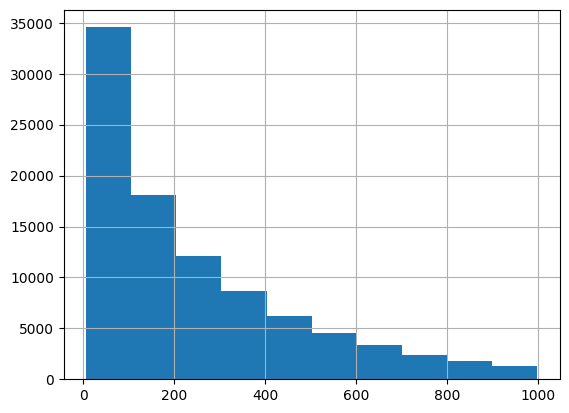

In [44]:
df_res['lens'].hist()
plt.show()

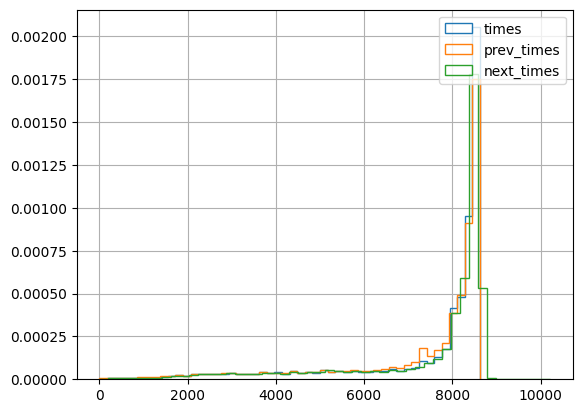

7311.544736615597 7434.210965742813 7466.25276510587


In [45]:
df_res['times'].hist(bins=50, legend='cur', density=True, histtype=u'step')
df_res['prev_times'].hist(bins=50, legend='prev', density=True, histtype=u'step')
df_res['next_times'].hist(bins=50, legend='next', density=True, histtype=u'step')
plt.show()

print(df_res['prev_times'].mean(), df_res['times'].mean(), df_res['next_times'].mean())

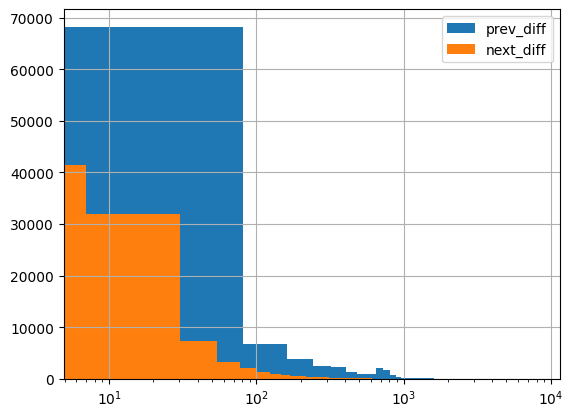

In [46]:
plt.xscale('log')
(df_res['prev_diff']).hist(bins=100, legend='prev')
(df_res['next_diff']).hist(bins=100, legend='next')
plt.show()

# Predict next time and types quality

In [56]:
%%time
ds_next = []

actual_times, predicted_times, actual_types, predicted_types = [], [], [], []

for batch in tqdm(valid_dl):
    
    (tm, tp), ln  = batch
    actual_times.append(tm[torch.arange(16), ln].cpu().numpy())
    actual_types.append(tp[torch.arange(16), ln].cpu().numpy())
    
    tm[torch.arange(16), ln] = 0
    tp[torch.arange(16), ln] = 0
    ln -= 1
    batch = (tm, tp), ln
    
    (tm, tp), ln  = generate_next(batch, model, device, sample=False)
    predicted_times.append(tm[torch.arange(16), ln].cpu().numpy())
    predicted_types.append(tp[torch.arange(16), ln].cpu().numpy())

5809it [00:38, 152.61it/s]

CPU times: user 29.6 s, sys: 7.21 s, total: 36.8 s
Wall time: 38.1 s


In [48]:
df_res = pd.DataFrame()

df_res['actual_times'] = np.concatenate(actual_times)
df_res['actual_types'] = np.concatenate(actual_types)
df_res['predicted_times'] = np.concatenate(predicted_times)
df_res['predicted_types'] = np.concatenate(predicted_types)
df_res['time_diff'] = df_res['predicted_times'] - df_res['actual_times'] 

df_res['actual_mcc'] = df_res['actual_types'] // 3 + 1
df_res['actual_amnt'] = df_res['actual_types'] % 3

df_res['predicted_mcc'] = df_res['predicted_types'] // 3 + 1
df_res['predicted_amnt'] = df_res['predicted_types'] % 3


df_res.head()

,actual_times,actual_types,predicted_times,predicted_types,time_diff,actual_mcc,actual_amnt,predicted_mcc,predicted_amnt
0,6649,0,6655,0,6,1,0,1,0
1,8492,26,8437,25,-55,9,2,9,1
2,8406,0,8415,8,9,1,0,3,2
3,8566,1,8571,1,5,1,1,1,1
4,7500,5,6954,4,-546,2,2,2,1


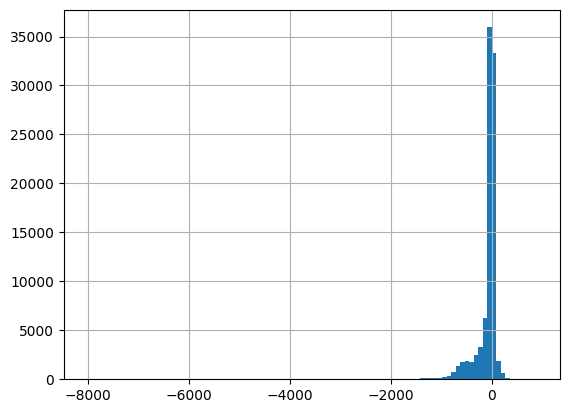

In [49]:
df_res['time_diff'].hist(bins=100)
plt.show()

In [50]:
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

print('Time MAE:', mean_absolute_error(df_res['actual_times'], df_res['predicted_times']))
print('Type accuracy:', accuracy_score(df_res['actual_types'], df_res['predicted_types']))
print('Amnt accuracy:', accuracy_score(df_res['actual_amnt'], df_res['predicted_amnt']))
print('MCC accuracy:', accuracy_score(df_res['actual_mcc'], df_res['predicted_mcc']))

Time MAE: 110.39942330865898
Type accuracy: 0.09204467206059563
Amnt accuracy: 0.2554226200723016
MCC accuracy: 0.3931937510759167


In [51]:
confusion_matrix(df_res['actual_amnt'], df_res['predicted_amnt'], normalize='true')

array([[0.48747722, 0.27863711, 0.23388566],
       [0.49123078, 0.36560922, 0.14316   ],
       [0.25628974, 0.68030596, 0.06340429]])

In [52]:
confusion_matrix(df_res['actual_mcc'], df_res['predicted_mcc'],  normalize='true')

array([[0.63102028, 0.2634136 , 0.05043304, ..., 0.        , 0.        ,
        0.        ],
       [0.19616935, 0.72688172, 0.02718414, ..., 0.        , 0.        ,
        0.        ],
       [0.47816286, 0.38461538, 0.04451958, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.5       , 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.56      , 0.44      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.35399674, 0.4730832 , 0.04404568, ..., 0.        , 0.        ,
        0.        ]])

# Levinstein

In [ ]:
def metric(real_trx, generated_trx):
    return lev(real_trx, generated_trx)

def evaluate(train_df, valid_df, model, n):
    score = 0
    
    for i in range(n): 
        
        if i == 0:
            batch = train_df[:][-1] #ластовые транзакции из трейна
        else:
            batch = valid[:][i]
            
        real = valid[:][i + 1]
        
        generated_trx = generate_next(batch, model)
        
        if i == 0:
            print('first trxs:', 'real:', real_trx, 'generated:', generated_trx)
            
        score += metric(real_trx, generated_trx)

    print('metric:', metric(real_trx, generated_trx))
    return score

In [ ]:
evaluate(train_df, valid_df, model, n=3)